In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [28]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [29]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

## Preparation

In [58]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'

In [59]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

In [60]:
## Make directories to save results
import shutil
# cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
cts_oi = ['CD14_low_CD16_positive_monocyte', 'effector_memory_CD8_positive_alpha_beta_T_cell', 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell', 'memory_B_cell', 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell']
for ct in cts_oi:
    print(ct)
    simdir = outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    if not os.path.exists(simdir + 'HVG_comparison'):
        os.mkdir(simdir + 'HVG_comparison')
    # Copy trained models to new directory
    model_dirs = [f'{simdir}/{x}' for x in os.listdir(simdir) if x.startswith('model_')]
    for m in model_dirs:
        new_m = m.replace('/model_', '/HVG_comparison/model_5000HVG_')
        print(new_m)
        shutil.copytree(m, new_m, dirs_exist_ok=True)

CD14_low_CD16_positive_monocyte
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_ctrlquery
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2atlas
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2ctrl
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_atlas
/lustre/s

In [28]:
('ACR', 'scArches', 5000, False) # done
('ACR', 'scArches', 2500, False)
('ACR', 'scArches', 10000, False)

('CR', 'scArches', 5000, False) # done
('CR', 'scVI', 5000, False) # done
('CR', 'scArches', 5000, True) 
('CR', 'scVI', 5000, True)
('CR', 'scArches', 2500, False) 
('CR', 'scVI', 2500, False) 
('CR', 'scArches', 2500, True) 
('CR', 'scVI', 2500, True)
('CR', 'scArches', 10000, False) 
('CR', 'scVI', 10000, False) 
('CR', 'scArches', 10000, True) 
('CR', 'scVI', 10000, True)

'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/model_5000HVG_atlasctrlquery'

```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/_misc/hvg_selection/

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
# cts="natural_killer_cell classical_monocyte naive_B_cell central_memory_CD4_positive_alpha_beta_T_cell"
cts="CD14_low_CD16_positive_monocyte effector_memory_CD8_positive_alpha_beta_T_cell naive_thymus_derived_CD4_positive_alpha_beta_T_cell memory_B_cell naive_thymus_derived_CD8_positive_alpha_beta_T_cell"
dirs=$(for c in $cts; do dirname $outdir/*500cells*${c}*/ACR_design.scArches_milo.h5ad; done)

for d in $dirs; do
    design=CR
      echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --fixed_hvgs --hvg_data atlas" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
     echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data atlas" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --fixed_hvgs --hvg_data ctrl" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrlquery" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

    done
```

```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/_misc/hvg_selection/

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
% cts="natural_killer_cell classical_monocyte naive_B_cell central_memory_CD4_positive_alpha_beta_T_cell"
cts="CD14_low_CD16_positive_monocyte effector_memory_CD8_positive_alpha_beta_T_cell naive_thymus_derived_CD4_positive_alpha_beta_T_cell memory_B_cell naive_thymus_derived_CD8_positive_alpha_beta_T_cell"
dirs=$(for c in $cts; do dirname $outdir/*500cells*${c}*/ACR_design.scArches_milo.h5ad; done)

for d in $dirs; do
    design=ACR
     echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrl" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrlquery" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

    done
```


## Parse results

In [8]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc
from oor_benchmark.methods.scArches_milo import run_milo

def harmonize_output(adata, signif_alpha=0.1):
#     if adata.isbacked:
#         sample_adata = adata.uns['nhood_adata'].to_memory().T
#     else:
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def read_oor_design_output(simdir, ref_design, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_seed')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.h5ad'
    adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=False)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def parse_design(adata, ref_design, hvg_data, emb_method):
    if 'sample_adata' not in adata.uns:
        harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    tpr_df['emb_method'] = emb_method
    tpr_df['hvg_data'] = hvg_data
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    auprc_df['emb_method'] = emb_method
    auprc_df['hvg_data'] = hvg_data
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    nhoods_df['emb_method'] = emb_method
    nhoods_df['hvg_data'] = hvg_data
    return(nhoods_df, tpr_df, auprc_df)

Global seed set to 0


In [9]:
n_hvgs = 5000
emb_method = 'scVI'
hvg_data = 'atlas'
population_obs = 'cell_type'

def read_result(simdir,
    n_hvgs = 5000,
    population_obs = 'cell_type'
    ):
    nhoods_df_all = pd.DataFrame()
    tpr_df_all = pd.DataFrame()
    auprc_df_all = pd.DataFrame()
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    for n_hvgs in [2500, 5000, 10000]:
        for emb_method in ['scVI', 'scArches']:
            for d in ['ACR', "CR"]:
                if d == 'CR':
                    for hvg_data in ['atlas', 'new','ctrl', 'ctrlquery']:
                        if hvg_data == 'atlas':
                            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                        else:
                            if n_hvgs == 5000:
                                h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                            else:
                                h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'    
                        try:
                            adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                        except:
                            continue
                        adata.obs['OOR_state_name'] = perturb_pop
                        print(d, hvg_data, emb_method, n_hvgs)
                        nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                        nhoods_df['n_hvgs'] = n_hvgs
                        tpr_df['n_hvgs'] = n_hvgs
                        auprc_df['n_hvgs'] = n_hvgs
                        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                        auprc_df_all = pd.concat([auprc_df_all, auprc_df])
                else:
                    hvg_data = 'new'
                    if n_hvgs == 5000:
                        h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                    else:
                        h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                    try:
                        adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                    except:
                        continue
                    adata.obs['OOR_state_name'] = perturb_pop
                    print(d, hvg_data, emb_method, n_hvgs)
                    nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                    nhoods_df['n_hvgs'] = n_hvgs
                    tpr_df['n_hvgs'] = n_hvgs
                    auprc_df['n_hvgs'] = n_hvgs
                    nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                    tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                    auprc_df_all = pd.concat([auprc_df_all, auprc_df])

    # print(auprc_df_all.head())
    nhoods_df_all.to_csv(simdir + f'/HVG_comparison/nhoods_obs.csv')
    tpr_df_all.to_csv(simdir + f'/HVG_comparison/TPR_res.csv')
    auprc_df_all.to_csv(simdir + f'/HVG_comparison/AUPRC_res.csv')

## Is HVG selection determining difference btw integration strategies in CR design?

In [11]:
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
simdirs = [outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]

In [12]:
nhoods_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()

population_obs = 'cell_type'
n_hvgs = 5000
params = (("CR", 'scVI', 'ctrl'),
    ("CR", 'scVI', 'new'),
    ("CR", 'scVI', 'atlas'),
    ("CR", 'scArches', 'new'),
    ("CR", 'scArches', 'ctrlquery'),
    ("CR", 'scArches', 'atlas'),
    ("ACR", 'scArches', 'atlas'),
    ("ACR", 'scArches', 'new'),
    ("ACR", 'scArches', 'ctrl'),
    ("ACR", 'scArches', 'ctrlquery'))

for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    for p in params:
        d, emb_method, hvg_data = p
        if hvg_data == 'new':
            h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
        else:
            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
        try:
            adata1 = milopy.utils.read_milo_adata(h5ad_file, backed=True)
        except:
            continue
        adata1.obs['OOR_state_name'] = perturb_pop
        adata1.uns['nhood_adata'] = adata1.uns['nhood_adata'].to_memory()
        nhoods_df, tpr_df, auprc_df = parse_design(adata1, d, emb_method=emb_method, hvg_data=hvg_data)
        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])

In [13]:
%%R -i auprc_df_all
head(auprc_df_all)

  Recall  Precision   AUPRC no_skill_thresh design OOR_state_name emb_method
1      1 0.06314700 0.42068        0.063147     CR   naive_B_cell       scVI
2      1 0.06321244 0.42068        0.063147     CR   naive_B_cell       scVI
3      1 0.06327801 0.42068        0.063147     CR   naive_B_cell       scVI
4      1 0.06334372 0.42068        0.063147     CR   naive_B_cell       scVI
5      1 0.06340956 0.42068        0.063147     CR   naive_B_cell       scVI
6      1 0.06347555 0.42068        0.063147     CR   naive_B_cell       scVI
  hvg_data
1     ctrl
2     ctrl
3     ctrl
4     ctrl
5     ctrl
6     ctrl


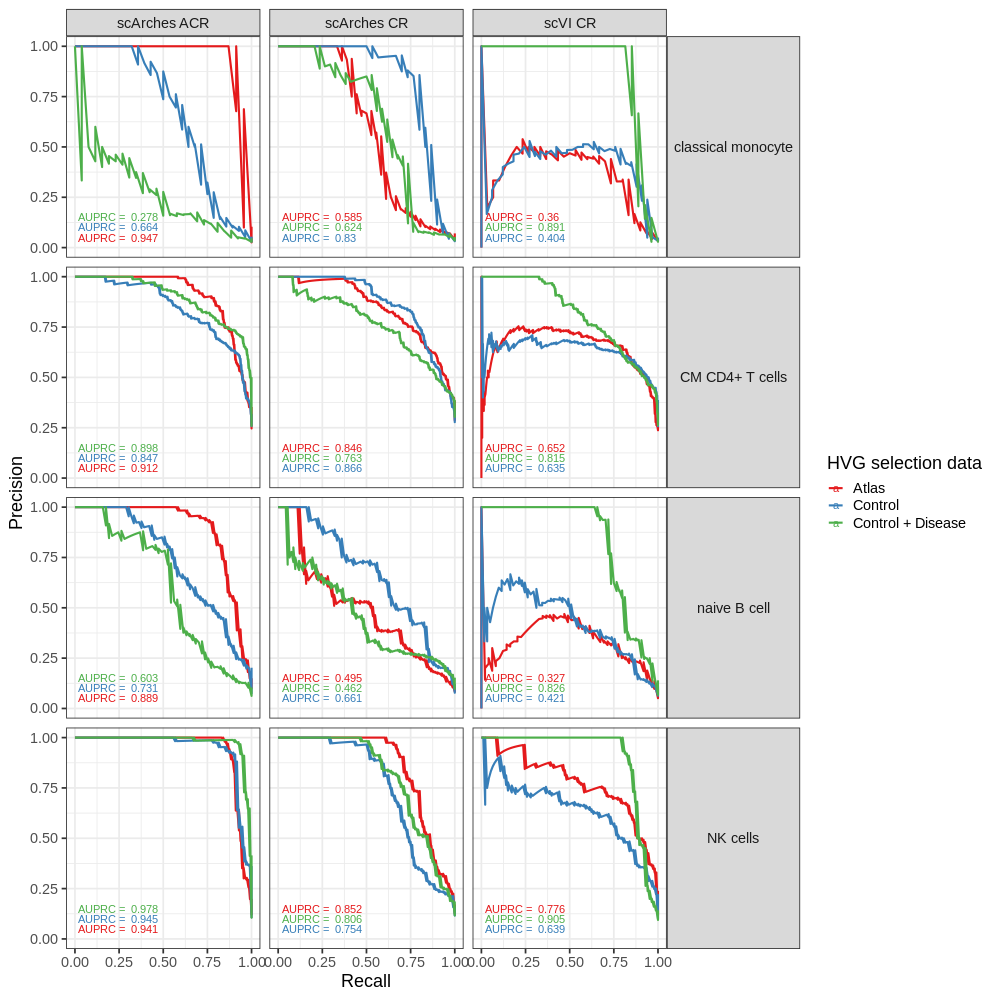

In [18]:
%%R -w 1000 -h 1000
rename_hvg_data <- c(
    'ctrl' = 'Control',
    'ctrlquery' = 'Control + Disease',
    'atlas' = 'Atlas'
)

auprc_df_all %>%
mutate(g = paste(emb_method, design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
ggplot(aes(Recall, Precision, color=hvg_data))+
geom_line(size=1) +
geom_text(data=. %>% distinct(AUPRC, hvg_data, OOR_state_name, g, hvg_data) %>% group_by(OOR_state_name, g) %>% mutate(id = row_number()), 
          aes(label=paste('AUPRC = ',round(AUPRC, 3)), y=id*0.05), x=0.02, hjust=0) +
# geom_hline(aes(yintercept=no_skill_thresh), linetype=2) +
facet_grid(OOR_state_name~g) +
scale_color_brewer(palette='Set1', name='HVG selection data') +
theme_bw(base_size=18) +
theme(strip.text.y=element_text(angle=0)) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_PR_curves.pdf', height=15, width=16) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_PR_curves.png', height=15, width=16) 


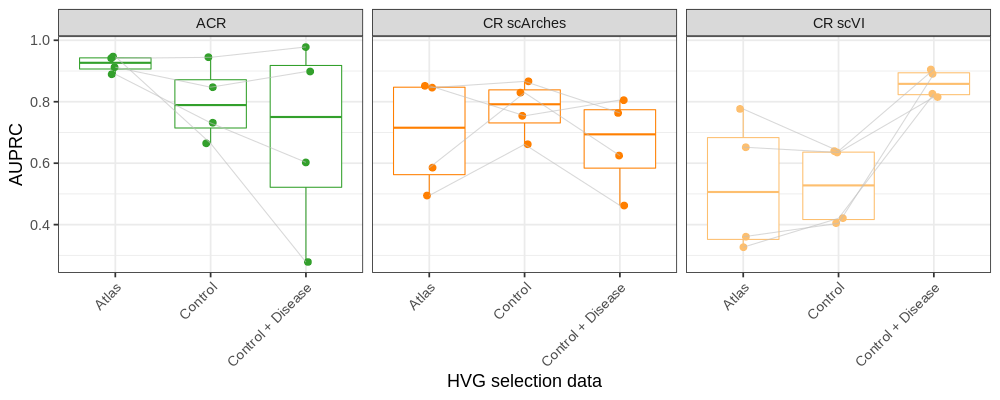

In [57]:
%%R -w 1000 -h 400
rename_hvg_data <- c(
    'ctrl' = 'Control',
    'ctrlquery' = 'Control + Disease',
    'atlas' = 'Atlas'
)

auprc_df_all %>%
mutate(g = ifelse(design == 'CR', paste(design, emb_method), design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
distinct(OOR_state_name,g, AUPRC, hvg_data, no_skill_thresh, design) %>%
rename(`HVG selection data` = hvg_data) %>%
ggplot(aes(`HVG selection data`, AUPRC, color=g)) +
geom_boxplot(outlier.alpha=0) +
geom_jitter(size=3, width=0.05) +
geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
theme_bw(base_size=24) +
facet_grid(.~g) +
scale_color_manual(values=design_palette, name='design') +
# xlab('design') +
theme_bw(base_size=18) +
guides(color='none') +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.pdf', height=6, width=12) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.png', height=6, width=12) 


In [55]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

n_hvgs = 5000
n_intersect_df = pd.DataFrame(columns=['ctrl_vs_ctrlquery', 'atlas_vs_ctrlquery', 'atlas_vs_ctrl'])
for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    vars_ctrl = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrl').index
    vars_ctrlquery = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrlquery').index
    vars_atlas = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_atlas').index
    n_intersect_df.loc[perturb_pop, 'ctrl_vs_ctrlquery'] = np.intersect1d(vars_ctrlquery, vars_ctrl).shape[0]
    n_intersect_df.loc[perturb_pop, 'atlas_vs_ctrlquery'] = np.intersect1d(vars_atlas, vars_ctrlquery).shape[0]
    n_intersect_df.loc[perturb_pop, 'atlas_vs_ctrl'] = np.intersect1d(vars_atlas, vars_ctrl).shape[0]
        

In [56]:
n_intersect_df

,ctrl_vs_ctrlquery,atlas_vs_ctrlquery,atlas_vs_ctrl
naive_B_cell,4077,3393,3254
central_memory_CD4_positive_alpha_beta_T_cell,3892,3320,3102
natural_killer_cell,4043,3481,3354
classical_monocyte,4041,3394,3252


### Measure gene relevance for disease

In [186]:
simdir = simdirs[2]

In [187]:
simdir

'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [223]:
from diff2atlas.utils import anndata2pseudobulk

def get_gene_DEscores(simdir):
    '''
    Compute DE score for each gene in a specific simulation
    '''
    adata = sc.read_h5ad(simdir+'/CR_design.scArches_milo.h5ad')
    
    # Pseudobulk 
    pbulk_oor = anndata2pseudobulk(adata[adata.obs['dataset_group'] == 'query'], group_by=['sample_id', 'OOR_state'], agg='s')
    sc.pp.normalize_per_cell(pbulk_oor)
    sc.pp.log1p(pbulk_oor)
    pbulk_oor.obs['OOR_state'] = pbulk_oor.obs['OOR_state'].astype("category")

    pbulk_cond = anndata2pseudobulk(adata, group_by=['sample_id', 'dataset_group'], agg='s')
    sc.pp.normalize_per_cell(pbulk_cond)
    sc.pp.log1p(pbulk_cond)
    
    # Gene gene scores (for condition and OOR state)
    sc.tl.rank_genes_groups(pbulk_cond, groupby='dataset_group', reference='ctrl')
    cond_rank_genes_df = sc.get.rank_genes_groups_df(pbulk_cond, group='query')
    sc.tl.rank_genes_groups(pbulk_oor, groupby='OOR_state', reference='0')
    oor_rank_genes_df = sc.get.rank_genes_groups_df(pbulk_oor, group='1')

    gene_score_df = pd.merge(cond_rank_genes_df[['names', 'scores']], oor_rank_genes_df[['names', 'scores']], on='names',suffixes = ['_condition', '_oor_state'])
    return(gene_score_df)

In [214]:
ctrl_hvgs = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrl').index
ctrlquery_hvgs = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrlquery').index

In [215]:
gene_score_df['Control HVGs'] = gene_score_df['names'].isin(ctrl_hvgs)
gene_score_df['Disease+Control HVGs'] = gene_score_df['names'].isin(ctrlquery_hvgs)

In [216]:
%%R -i gene_score_df
head(gene_score_df)

            names scores_condition scores_oor_state Control HVGs
0 ENSG00000176720         7.857924         6.649512        FALSE
1 ENSG00000117281         7.721545        12.743175         TRUE
2 ENSG00000150045         7.303252        16.544872         TRUE
3 ENSG00000186891         6.233237        10.786356         TRUE
4 ENSG00000100027         6.230417         9.419113        FALSE
5 ENSG00000100385         6.093289        20.694040         TRUE
  Disease+Control HVGs
0                 TRUE
1                 TRUE
2                 TRUE
3                 TRUE
4                 TRUE
5                 TRUE


In [217]:
sum(gene_score_df.loc[gene_score_df['Disease+Control HVGs'], 'scores_oor_state'] != 0)

4999

In [191]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


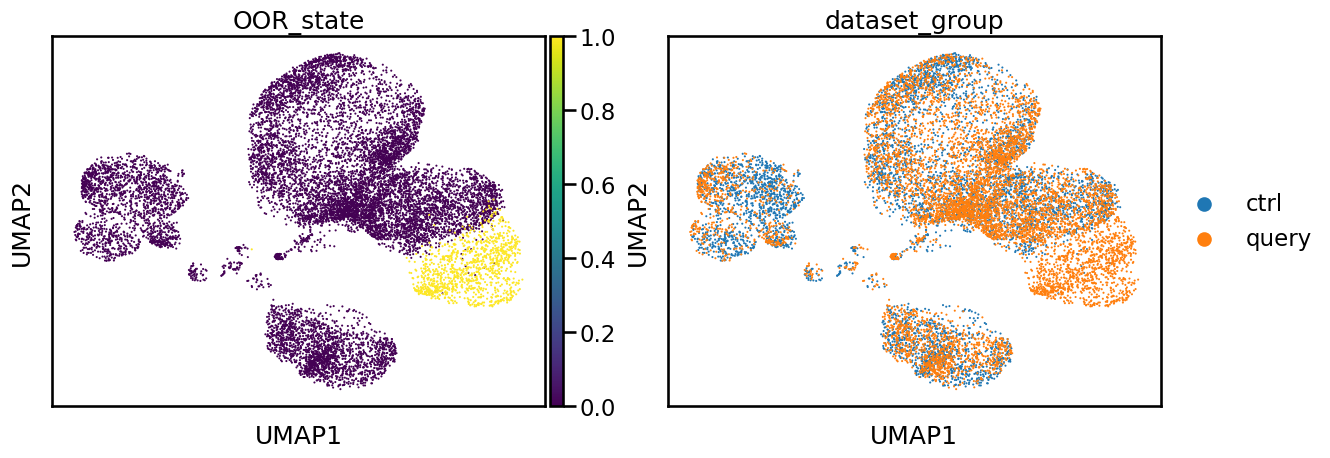

In [192]:
sc.pl.umap(adata, color=['OOR_state', 'dataset_group'])

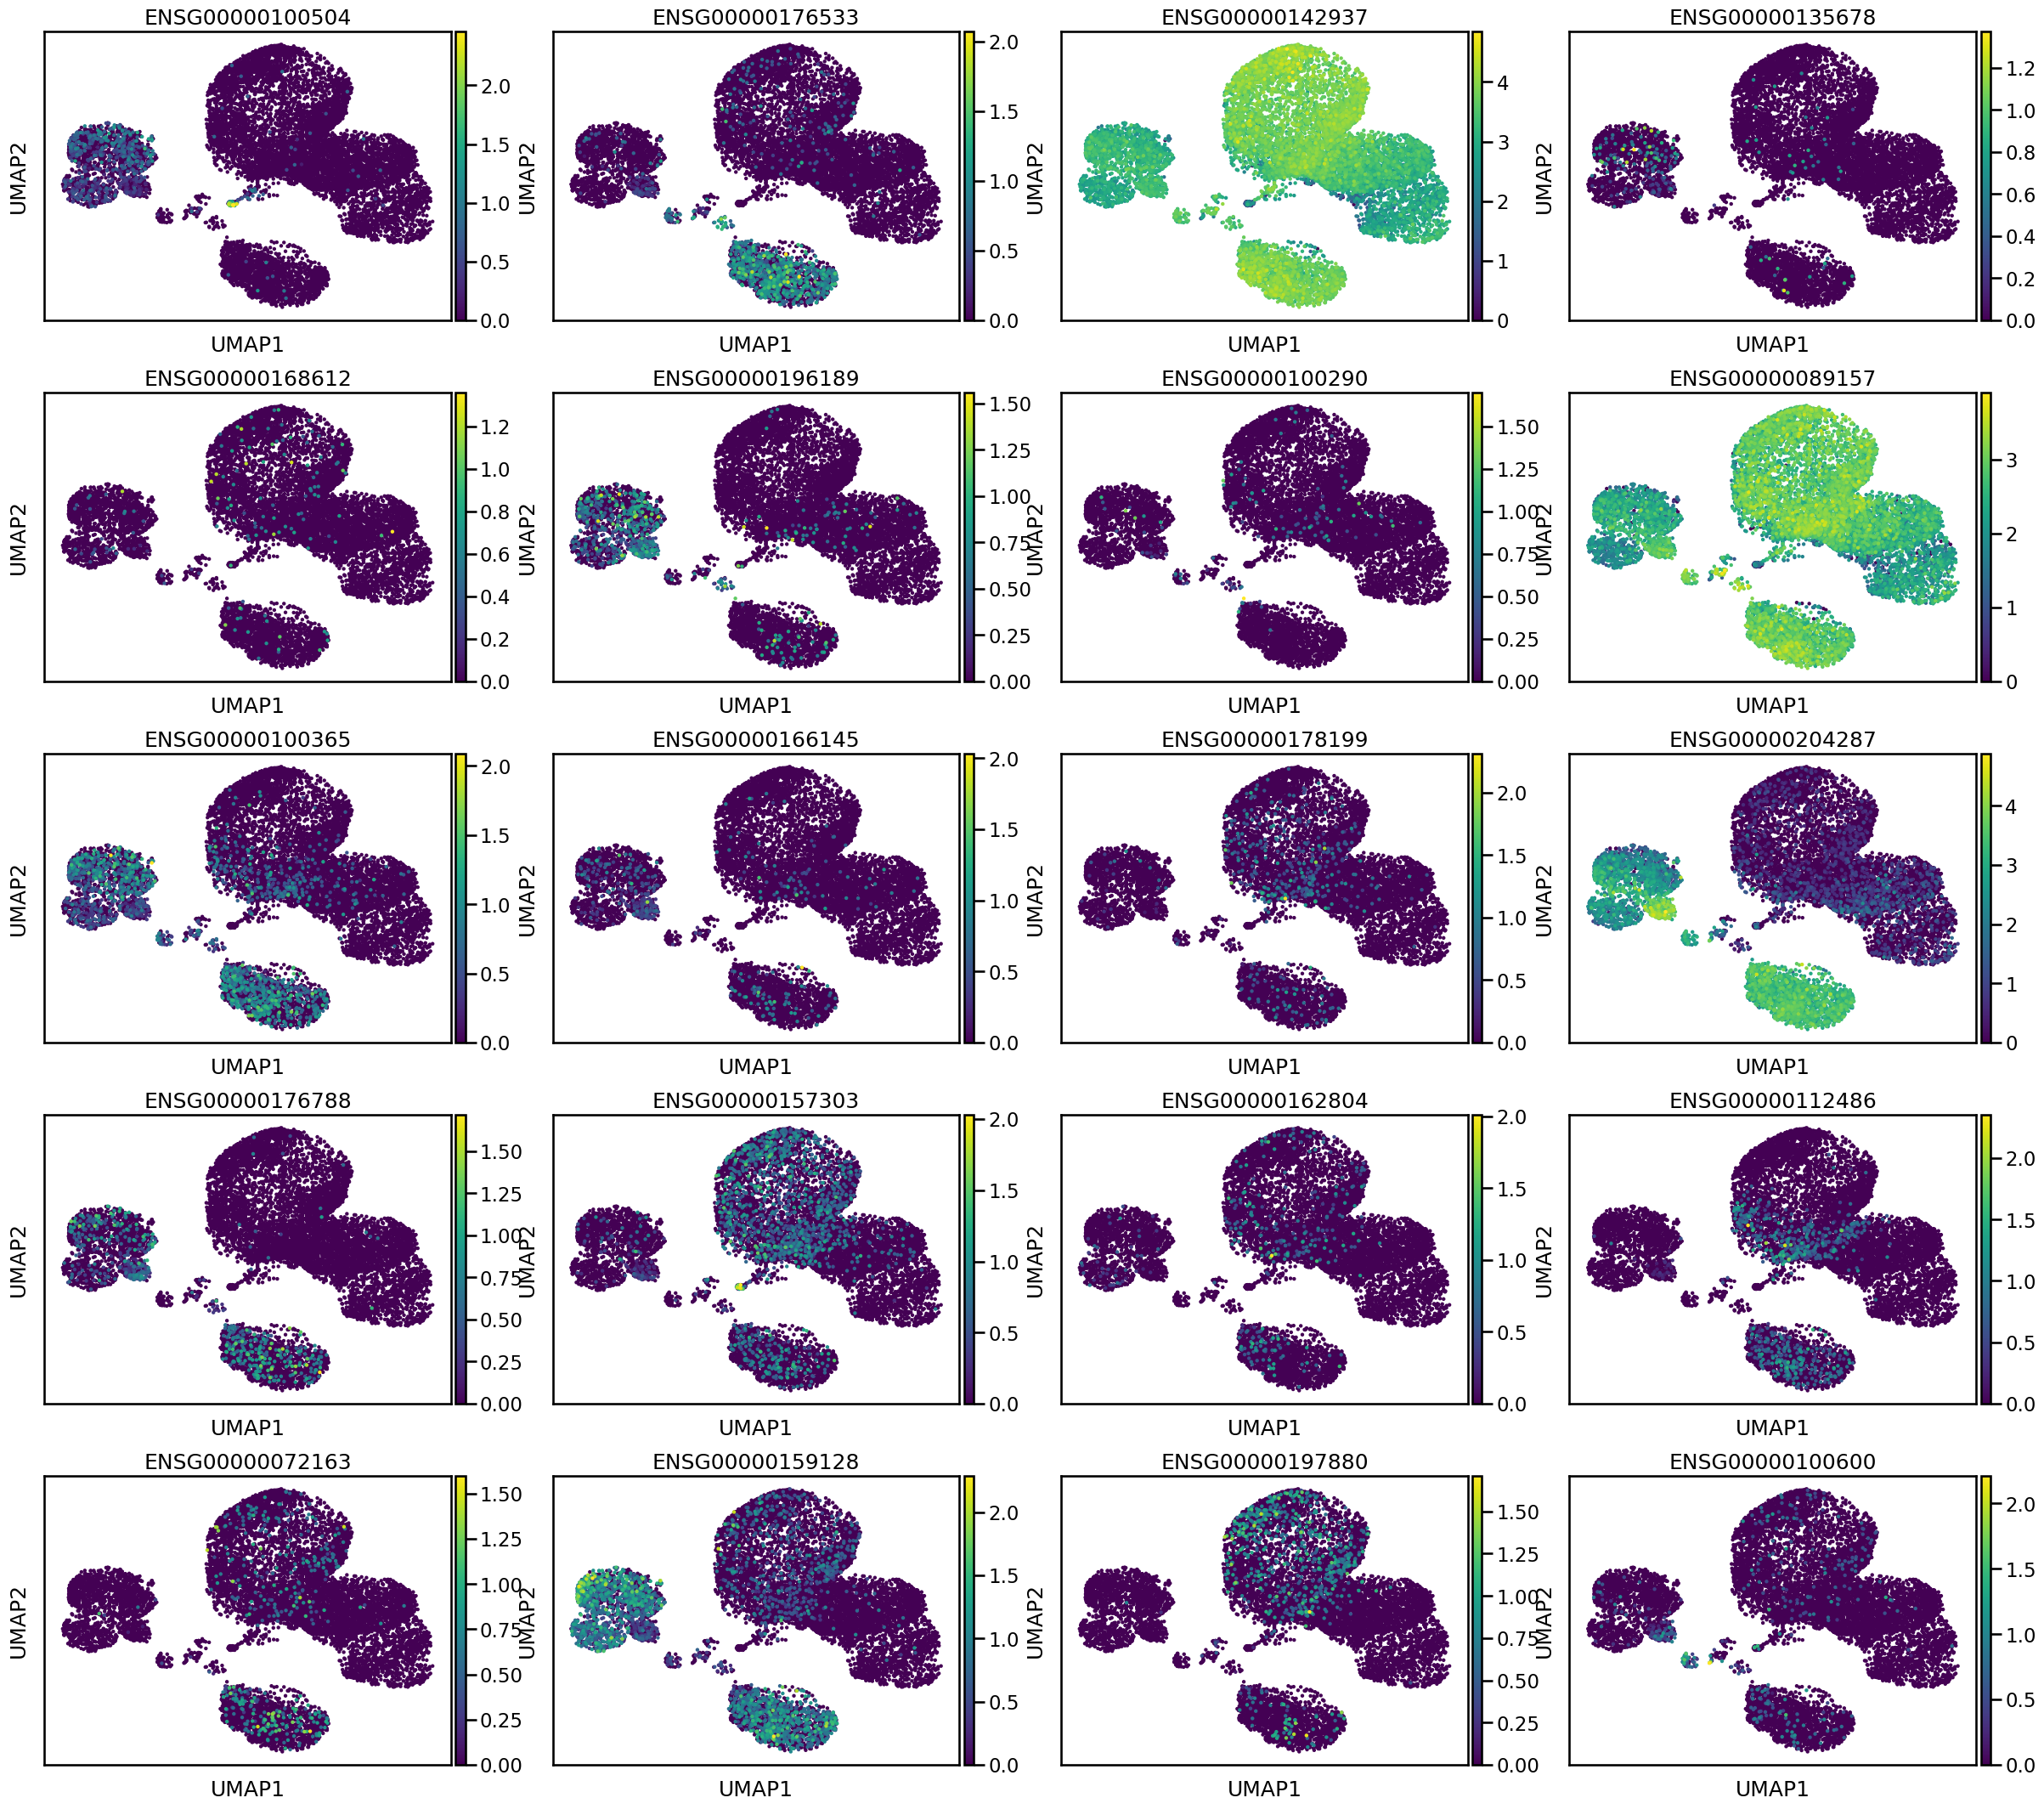

In [219]:
sc.pl.umap(adata, color=oor_rank_genes_df[-20:]['names'], size=40)

In [226]:
adata.obs_names[10] in adata.obs_names[10:]

True

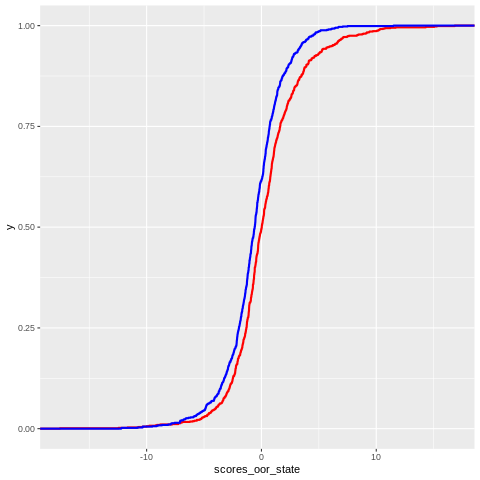

In [222]:
%%R
gene_score_df %>%
#     mutate(HVG_type = case_when(
#         `Disease+Control HVGs` & `Control HVGs` ~ 'both',
#         `Disease+Control HVGs` & !`Control HVGs` ~ 'Disease only',
#         !`Disease+Control HVGs` & !`Control HVGs` ~ 'None',
#     )) %>%
    ggplot(aes(scores_oor_state)) +
    stat_ecdf(data=. %>% filter(`Disease+Control HVGs` & !`Control HVGs`), color='red', size=1) +
    stat_ecdf(data=. %>% filter(`Control HVGs`  & !`Disease+Control HVGs`), color='blue', size=1)

### Compare HVG numvers

In [99]:
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
simdirs = [outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]
for d in simdirs:
    read_result(d)


Reading naive_B_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrlquery scArches 5000
CR new scVI 10000
ACR new scArches 10000
CR new scArches 10000
Reading central_memory_CD4_positive_alpha_beta_T_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrlquery scArches 5000
CR new scVI 10000
ACR new scArches 10000
Reading natural_killer_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrl

In [35]:
nhoods_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
for simdir in simdirs:
    nh_df = pd.read_csv(f'{simdir}/HVG_comparison/nhoods_obs.csv', index_col=0)
    tpr_df = pd.read_csv(f'{simdir}/HVG_comparison/TPR_res.csv', index_col=0)
    auprc_df = pd.read_csv(f'{simdir}/HVG_comparison/AUPRC_res.csv', index_col=0)
    auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    nhoods_df_all = pd.concat([nhoods_df_all, nh_df])
    tpr_df_all = pd.concat([tpr_df_all, tpr_df])

In [36]:
auprc_df_all

,Recall,Precision,AUPRC,no_skill_thresh,design,OOR_state_name,emb_method,hvg_data,n_hvgs
0,1.000000,0.057411,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
1,1.000000,0.057471,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
2,1.000000,0.057531,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
3,1.000000,0.057592,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
4,1.000000,0.057652,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
...,...,...,...,...,...,...,...,...,...
958,0.173913,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
959,0.130435,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
960,0.086957,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
961,0.043478,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000


In [39]:
auprc_pl = auprc_df_all[auprc_df_all['hvg_data'] == 'new']
# auprc_pl = auprc_pl[['AUPRC','design', 'OOR_state_name', 'design', 'OOR_state_name', 'emb_method', 'hvg_data', 'n_hvgs']].drop_duplicates()

In [40]:
%%R -i auprc_pl -i tpr_df_all
head(auprc_pl)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision     AUPRC no_skill_thresh design OOR_state_name emb_method
1      1 0.05741127 0.8927167      0.05741127     CR   naive_B_cell       scVI
2      1 0.05747126 0.8927167      0.05741127     CR   naive_B_cell       scVI
3      1 0.05753138 0.8927167      0.05741127     CR   naive_B_cell       scVI
4      1 0.05759162 0.8927167      0.05741127     CR   naive_B_cell       scVI
5      1 0.05765199 0.8927167      0.05741127     CR   naive_B_cell       scVI
6      1 0.05771249 0.8927167      0.05741127     CR   naive_B_cell       scVI
  hvg_data n_hvgs
1      new   2500
2      new   2500
3      new   2500
4      new   2500
5      new   2500
6      new   2500


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


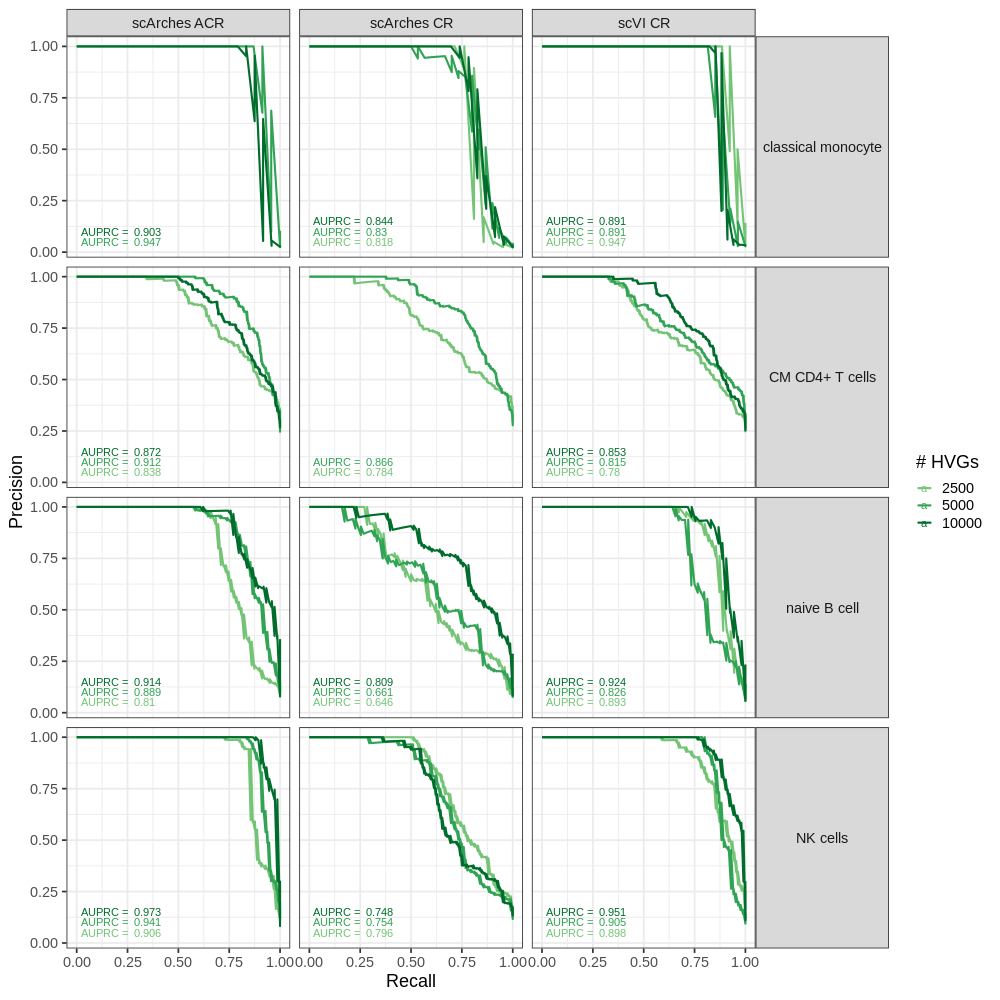

In [63]:
%%R -w 1000 -h 1000
my_colors <- RColorBrewer::brewer.pal(5, "Greens")[3:5]
        
auprc_pl %>%
mutate(g = paste(emb_method, design)) %>%
filter(g != 'scVI ACR') %>%
# mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
# mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
# mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
# mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
ggplot(aes(Recall, Precision, color=as.factor(n_hvgs)))+
geom_line(size=1) +
geom_text(data=. %>% distinct(AUPRC, hvg_data, OOR_state_name, g, n_hvgs) %>% group_by(OOR_state_name, g) %>% mutate(id = row_number()), 
          aes(label=paste('AUPRC = ',round(AUPRC, 3)), y=id*0.05), x=0.02, hjust=0) +
facet_grid(OOR_state_name~g) +
scale_color_manual(values=my_colors, name='# HVGs') +
theme_bw(base_size=18) +
theme(strip.text.y=element_text(angle=0)) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_no_PR_curves.pdf', height=15, width=16) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_no_PR_curves.png', height=15, width=16) 


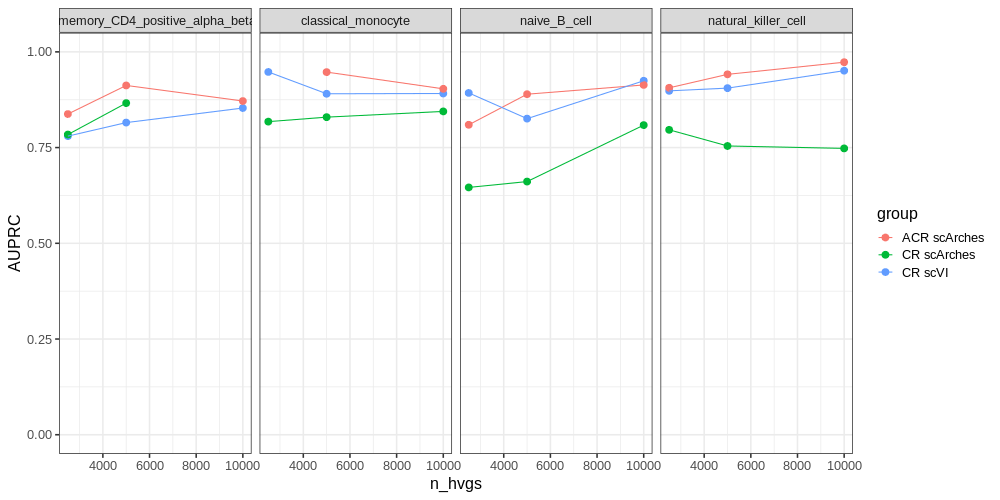

In [248]:
%%R -w 1000 -h 500
auprc_pl %>%
mutate(group = paste(design, emb_method)) %>%
filter(group != 'ACR scVI') %>%
ggplot(aes(n_hvgs, AUPRC, color=group)) +
geom_point(size=3) +
geom_line(aes(group=group)) +
ylim(0,1) +
theme_bw(base_size=16) +
facet_grid(.~OOR_state_name) 